# Семинар 2

In [1]:
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2)


# Минутка теории

## Обозначения

$\theta_0$ -- истинные параметры, $\hat{\theta}$ -- MLE-оценка.

Разложим лайклихуд по формуле Тейлора в ряд вокруг $\hat\theta$:

$$\log L(\theta) \approx \log L(\hat\theta) + S(\hat{\theta}) (\theta - \hat{\theta}) - \frac{1}{2} I(\hat{\theta}) (\theta - \hat{\theta})^2 $$

Производная лайклихуда часто называется scoring function и по определению $\hat\theta$:

$$S(\hat\theta) = \frac{d}{d\theta} \log L(\theta) |_{\hat\theta} = 0$$

## Информация Фишера

$$I(\theta) = \sum_{x_i} E_{\theta} \left( \frac{d}{d\theta} \log p(x_i | \theta) \right) = - \sum_{x_i} E_{p(x|\theta)} \frac{d^2}{d\theta^2} \log p(x_i | \theta) = - n E_{p(x|\theta)} \frac{d^2}{d\theta^2} \log p(x_i | \theta)$$

Физический смысл: сколько информации содержится в измерении $x_i$ (чуть ближе с информацией Фишера мы познакомимся в задачке в конце семинара, это очень крутой инструмент несмотря (?) на его простоту!).

Есть две информации Фишера: ожидаемая (expected, та которая написана выше) и наблюдаемая (observed). Наблюдаемая информация Фишера это просто гессиан лайклихуда:

$$I(\theta) = - \frac{d^2}{d\theta^2} \log p(x | \theta) = -\sum_{x_i} \frac{d^2}{d\theta^2} \log p(x_i | \theta)$$

## Теорема Вальда

$$\sqrt{n}(\hat{\theta} - \theta_0) \rightarrow \mathcal{N}\left(0, \frac{1}{I(\theta)}\right)$$

Выводится путём разложение лог-лайклихуда в ряд Тейлора до $\frac{d^3 L}{d\theta^3}$ и применения закона больших чисел при суммировании лайклихудов по измерениям $x_i$.

Замечу что тут $I(\theta)$ может быть как наблюдаемая, так и ожидаемая информация Фишера. В классических учебниках обычно говорят ожидаемую информацию Фишера, но некоторые статьи утверждают что наблюдаемая информация Фишера даёт лучше оценки [1].

[1] https://academic.oup.com/biomet/article-abstract/65/3/457/233667?redirectedFrom=fulltext



# 1. Метод Вальда для оценки доверительных интервалов


## Оценка интервалов Вальда на примере распределения Бернулли 

Корректность применения теоремы Вальда для оценки интервалов сильно зависит от того насколько лог-лайклихуд квадратичен (i.e. нормален) в окрестности $\theta_0$.

На примере распределения Бернулли мы проверим насколько регулярен лайклихуд при разных размерах выборки и параметризациях.

In [2]:
x = 8
n = 10
theta_hat = x / n

In [3]:
# настоящие функции лайклихуда и скоринга
log_likelihood = lambda x, n, theta, theta_hat: x * np.log(theta) + (n - x) * np.log(1 - theta)
score_function = lambda x, n, theta, theta_hat: (x / theta - (n - x) / (1 - theta))

In [4]:
# наблюдаемая информация фишера
I_theta = lambda x, n, theta: x / theta**2 + (n - x) / (1 - theta)**2

In [5]:
# квадратичная и линейная модель лайклихуда и скоринга
log_likelihood_quadratic = lambda x, n, theta, theta_hat: -I_theta(x, n, theta_hat) * (theta - theta_hat)**2 / 2
score_function_linear = lambda x, n, theta, theta_h2at: -I_theta(x, n, theta_hat) * (theta - theta_hat)

In [6]:
EPS = 0.01
theta = np.linspace(0.5, 1 - EPS, 100)

### Nota bene

При рисовании скоринг функции вместо $\theta$ vs $S(\theta)$ мы будем рисовать следующее:

$$\textrm{Ось X: }(\theta - \hat\theta) \sqrt{I(\hat\theta})$$
$$\textrm{Ось Y: }\frac{S(\theta)}{\sqrt{I(\hat\theta)}}$$

Плюсы: безразмерность и независимость от скейлинга.

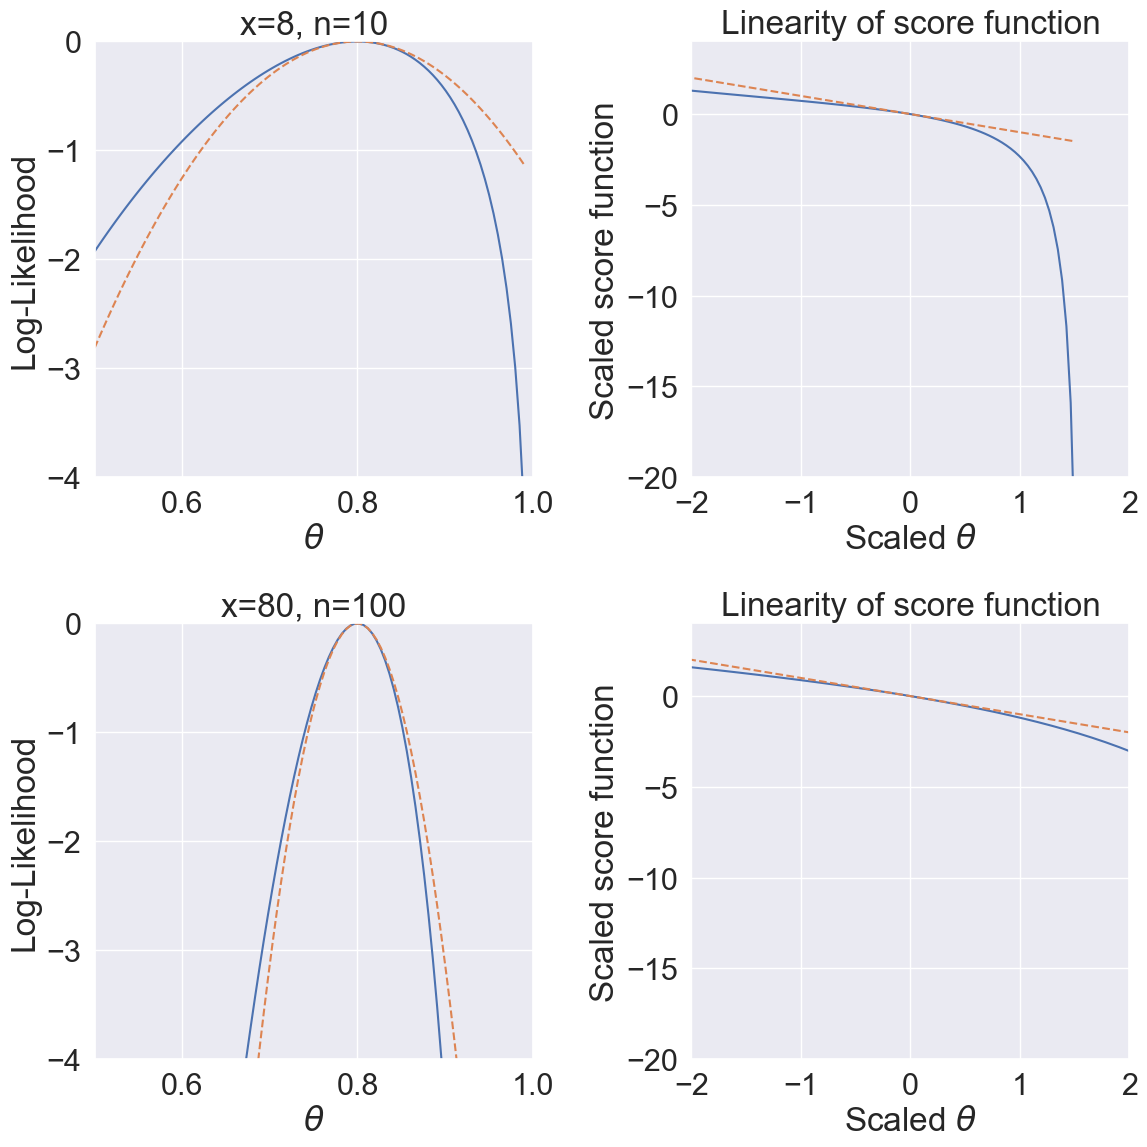

In [7]:
# plot both 
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

x = 8
n = 10
theta_hat = x / n


# plot log likelihood quadratic and true on theta n = 10
axes[0][0].plot(theta, log_likelihood(x, n, theta, theta_hat) - log_likelihood(x, n, theta, theta_hat).max(), label="True likelihood")
axes[0][0].plot(theta, log_likelihood_quadratic(x, n, theta, theta_hat), linestyle="--", label="Quadratic likelihood")
axes[0][0].set_xlim(0.5, 1)
axes[0][0].set_ylim(-4., 0.)
axes[0][0].set_title("x=8, n=10")
axes[0][0].set_ylabel("Log-Likelihood")
axes[0][0].set_xlabel(r"$\theta$")


# plot score n = 10
axes[0][1].plot(
    (theta - theta_hat) * np.sqrt(I_theta(x, n, theta_hat)), 
    score_function(x, n, theta, theta_hat) / np.sqrt(I_theta(x, n, theta_hat)), 
    label="True score function"
)
axes[0][1].plot(
    (theta - theta_hat) * np.sqrt(I_theta(x, n, theta_hat)), 
    score_function_linear(x, n, theta, theta_hat) / np.sqrt(I_theta(x, n, theta_hat)), 
    linestyle="--", label="Linear score function"
)
axes[0][1].set_xlim(-2, 2)
axes[0][1].set_title("Linearity of score function")
axes[0][1].set_ylabel("Scaled score function")
axes[0][1].set_xlabel(r"Scaled $\theta$")
axes[0][1].set_ylim(-20., 4.)



x = 80
n = 100
theta_hat = x / n

# ll n = 100
axes[1][0].plot(theta, log_likelihood(x, n, theta, theta_hat) - log_likelihood(x, n, theta, theta_hat).max(), label="True likelihood")
axes[1][0].plot(theta, log_likelihood_quadratic(x, n, theta, theta_hat), linestyle="--", label="Quadratic likelihood")
axes[1][0].set_xlim(0.5, 1)
axes[1][0].set_ylim(-4., 0.)
axes[1][0].set_title("x=80, n=100")
axes[1][0].set_ylabel("Log-Likelihood")
axes[1][0].set_xlabel(r"$\theta$")

# plot score n = 100 
axes[1][1].plot(
    (theta - theta_hat) * np.sqrt(I_theta(x, n, theta_hat)), 
    score_function(x, n, theta, theta_hat) / np.sqrt(I_theta(x, n, theta_hat)), 
    label="True score function"
)
axes[1][1].plot(
    (theta - theta_hat) * np.sqrt(I_theta(x, n, theta_hat)), 
    score_function_linear(x, n, theta, theta_hat) / np.sqrt(I_theta(x, n, theta_hat)), 
    linestyle="--", label="Linear score function"
)
axes[1][1].set_xlim(-2, 2)
axes[1][1].set_title("Linearity of score function")
axes[1][1].set_ylabel("Scaled score function")
axes[1][1].set_xlabel(r"Scaled $\theta$")
axes[1][1].set_ylim(-20., 4.)

plt.tight_layout()
plt.show()

## Попробуем заменить параметризацию

$$\psi = \log \frac{\theta}{1 - \theta}$$



### Как изменится информация Фишера?

Применим правила дифференциирования сложных функций и факт что $E_{p(x|\theta)}\frac{d \log p(x | \theta)}{d\theta} = 0$:

$$I(\psi) = -E_{p(x|\psi)} \frac{d^2}{d\psi^2} \log p(x | \psi(\theta)) = -E_{p(x|\theta)} \left(\frac{d^2\log p(x | \psi(\theta))}{d\theta^2}  \left(\frac{d \theta}{d\psi}\right)^2 + \frac{d \log p(x | \psi(\theta))}{d\theta}  \frac{d^2 \theta}{d\psi^2} \right) = -E_{p(x|\theta)} \frac{d^2 \log p(x | \psi(\theta))}{d\theta^2}  \left(\frac{d \theta}{d\psi}\right)^2$$


$$I(\psi) = I(\theta) \left(\frac{d \theta}{d\psi}\right)^2$$

#### Заметим что это и есть основная формула дельта-метода о связи дисперсий в разных параметризациях!


### Как изменится $S(\psi)$?


$$S(\psi(\theta)) = \frac{d}{d\psi} \log p(x | \psi(\theta)) = S(\theta) \frac{d \theta}{d\psi}$$

In [8]:
from scipy.special import expit
psi = lambda theta: np.log(theta / (1 - theta))
psi_grad = lambda theta: expit(psi(theta)) * (1 - expit(psi(theta))) # d \theta / d \psi

I_psi = lambda x, n, theta_hat: I_theta(x, n, theta_hat) * psi_grad(theta_hat)**2

In [9]:
# квадратичная и линейная модель лайклихуда и скоринга
log_likelihood_quadratic_psi = lambda x, n, theta, theta_hat: -I_psi(x, n, theta_hat) * (psi(theta) - psi(theta_hat))**2 / 2
score_function_linear_psi = lambda x, n, theta, theta_hat: -I_psi(x, n, theta_hat) * (psi(theta) - psi(theta_hat))

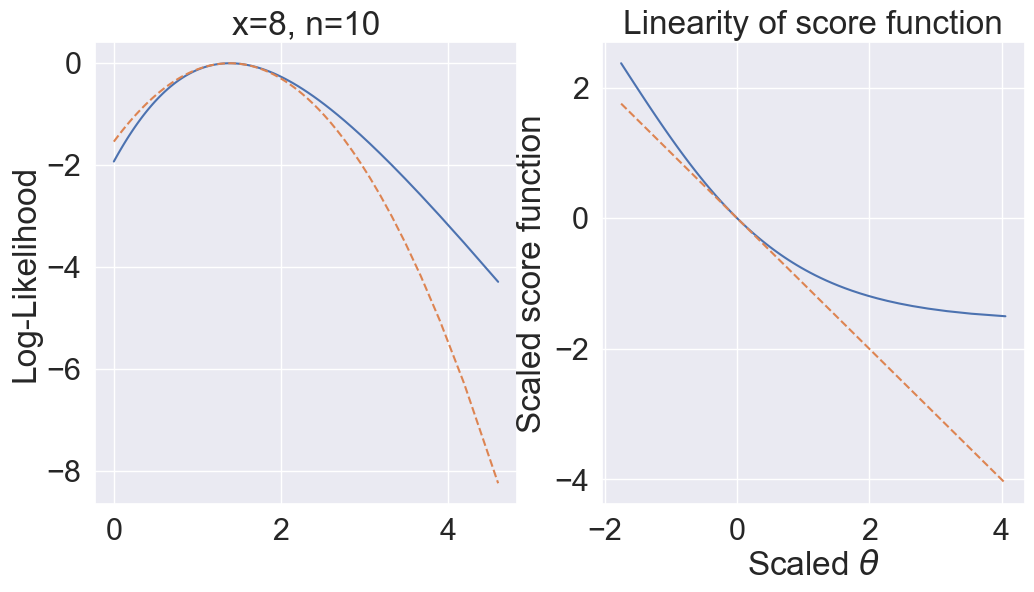

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# plot log likelihood quadratic and true on psi
x = 8
n = 10
theta_hat = x / n

axes[0].set_title("x=8, n=10")
axes[0].set_ylabel("Log-Likelihood")

# plot log likelihood quadratic and true on theta n = 10
axes[0].plot(
    psi(theta), 
    log_likelihood(x, n, theta, theta_hat) - log_likelihood(x, n, theta, theta_hat).max(), 
    label="True likelihood")
axes[0].plot(psi(theta), log_likelihood_quadratic_psi(x, n, theta, theta_hat), linestyle="--")

# plot score n = 10
axes[1].plot(
    (psi(theta) - psi(theta_hat)) * np.sqrt(I_psi(x, n, theta_hat)), 
    score_function(x, n, theta, theta_hat) * psi_grad(theta) / np.sqrt(I_psi(x, n, theta_hat)), 
    label="True score function"
)
axes[1].plot(
    (psi(theta) - psi(theta_hat)) * np.sqrt(I_psi(x, n, theta_hat)), 
    score_function_linear_psi(x, n, theta, theta_hat) / np.sqrt(I_psi(x, n, theta_hat)), 
    linestyle="--", label="Linear score function"
)

axes[1].set_title("Linearity of score function")
axes[1].set_ylabel("Scaled score function")
axes[1].set_xlabel(r"Scaled $\theta$")

plt.show()

## Посчитаем покрытие


In [11]:
import scipy.stats as st
q = st.norm.ppf(0.98) # 90% интервал
true_p = 0.5
psi_inverse = lambda psi: expit(psi)

In [12]:
coverage_theta = []
coverage_psi = []

for i in range(10000):
    x = np.random.binomial(n=1, p=true_p, size=10)
    p = np.clip(x.mean(), 1e-5, 1 - 1e-5)
    p_psi = psi(p)
    
    std_theta = 1 / np.sqrt(I_theta(x.sum(), len(x), p))
    std_psi = 1 / np.sqrt(I_psi(x.sum(), len(x), p))
    
    if p - q * std_theta < true_p < p + q * std_theta:
        coverage_theta.append(1)
    else:
        coverage_theta.append(0)
    
    if psi_inverse(p_psi - q * std_psi) < true_p < psi_inverse(p_psi + q * std_psi):
        coverage_psi.append(1)
    else:
        coverage_psi.append(0)

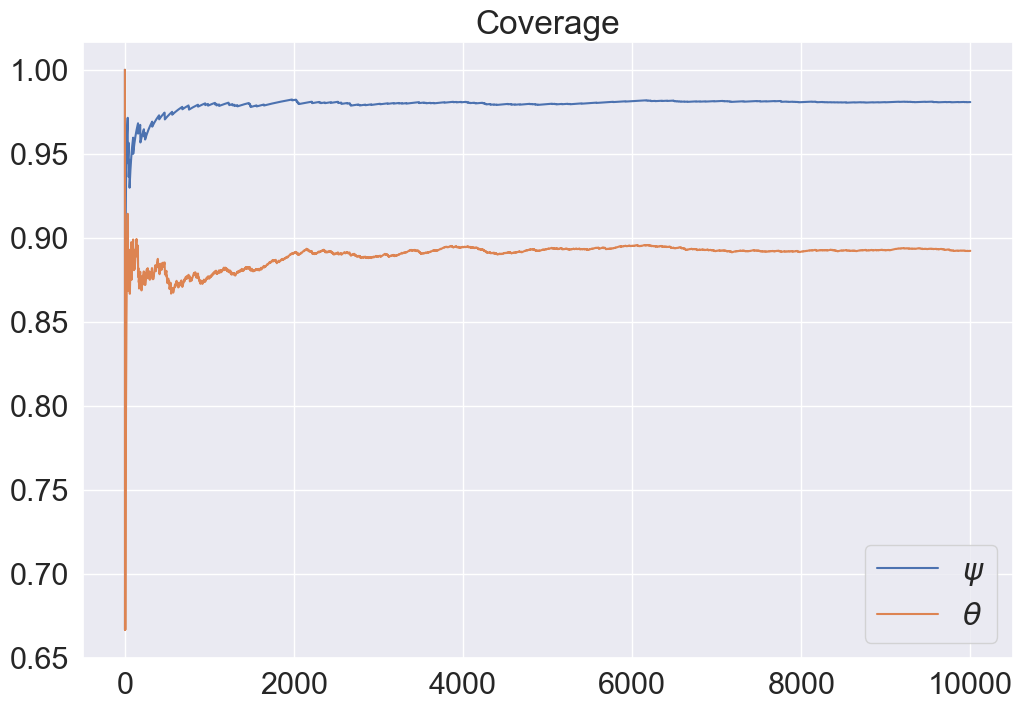

In [13]:
plt.figure(figsize=(12, 8))
plt.title("Coverage")
plt.plot(np.cumsum(coverage_psi) / np.cumsum(np.ones_like(coverage_psi)), label=r"$\psi$")
plt.plot(np.cumsum(coverage_theta) / np.cumsum(np.ones_like(coverage_theta)), label=r"$\theta$")
plt.legend()

## 1.2 (Пример) Вернёмся к задаче с "относительной приспособленностью"

### Шаг 1. Посчитаем ожидаемую матрицу Фишера для гамма-распределения

In [14]:
from scipy.special import polygamma

def I_gamma(alpha, beta):
    I_matrics = [
        [-polygamma(1, alpha), 1 / beta],
        [1 / beta, -alpha / beta**2]
    ]
    return -np.array(I_matrics)

In [15]:
from scipy.stats import gamma
alpha = 0.23
beta = 5.35
X = gamma.rvs(scale=1 / beta, a=alpha, size=100)

I_matrics = len(X) * I_gamma(alpha=alpha, beta=beta)

In [16]:
variance_matrix = np.linalg.inv(I_matrics)

### Шаг 2. Мы хотим одномерные интервалы

In [17]:
q = st.norm.ppf(.95) # 95% интервал
std = np.sqrt(variance_matrix[0, 0])

In [18]:
alpha - std * q, alpha + std * q

(0.18859328603995396, 0.27140671396004606)

### Шаг 3. Мы хотим двумерный интервал

Тут нужно немного геометрии для построения эллипса который содержит 95% массы, но выкладки не сложные, поэтому предлагаю прочитать их здесь: 
https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

In [19]:
eigen_vals, eigen_vectors = np.linalg.eig(variance_matrix)

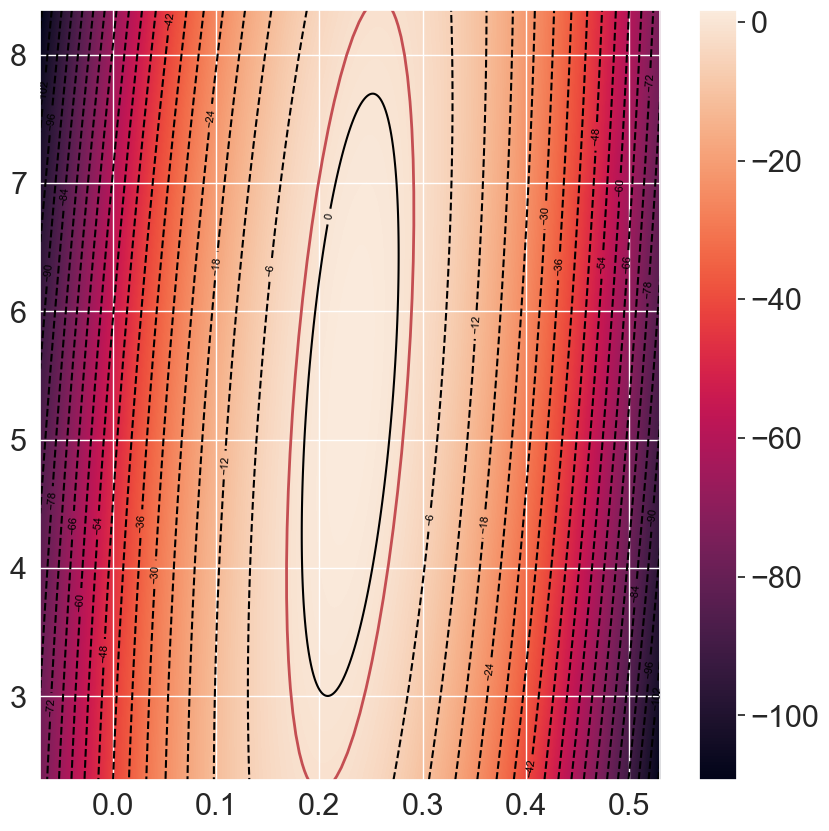

In [20]:
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

N = 500
x = np.linspace(alpha - 0.3, alpha + 0.3, N)
y = np.linspace(beta - 3., beta + 3., N)
X,Y = np.meshgrid(x, y)
pos = np.array([X.flatten(), Y.flatten()]).T
rv = multivariate_normal([alpha, beta], variance_matrix)
logpdf = rv.logpdf(pos).reshape(N, N)

fig = plt.figure(figsize=(10, 10))
contours = plt.contour(X, 
                       Y, 
                       logpdf, 
                       20, 
                       colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(logpdf, extent=[alpha - 0.3, alpha + 0.3, beta - 3., beta + 3.], 
           aspect='auto', origin='lower', alpha=1.)
plt.colorbar();

ax = plt.gca()
angle = np.arctan2(eigen_vectors[0][1], eigen_vectors[0][0])
ellipse = Ellipse(xy=(alpha, beta), 
                  width=2 * np.sqrt(5.991 * eigen_vals[0]), 
                  height=2 * np.sqrt(5.991 * eigen_vals[1]), 
                  angle=-angle * 180 / np.pi,
                  edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

plt.show()

## (ДЗ) Натурализация интервалов Вальда

Как вы заметили, изменение параметризации сильно влияет на построение интервалов Вальда. Для того чтобы найти оптимальную параметризацию можно использовать дельта-метод для преобразования $g(\theta)$ для которого дисперсия будет константной.

Для этого необходимо решить дифференциальное уравнение:

$$\sigma(g(\theta)) = \frac{1}{\sqrt{I(\theta)}} g'(\theta) = \mathrm{const}$$

$$g'(\theta) \sim \sqrt{I(\theta)} $$

В домашнем задании вы вопробуете это сделать и проверить покрытие для гамма-распределения с стандартной параметризацией и той которую нашли вы.


## 1.2 (Extra) Дельта-метод для построения доверительного интервала корреляции

## Определение дельта-метода

(Очень ванильное определение дельта-метода, мне больше нравится через информацию Фишера) Пусть $X$ распределено нормально и $\sqrt{n}(\bar{X}_n - \mu) \rightarrow N(0, \sigma^2)$, тогда:

$$\sqrt{n}(g(\bar{X}_n) - g(\mu)) \rightarrow \mathcal{N}\left(0, \sigma^2 g'(\mu)^2\right)$$

Efron (1982) исследовал результаты здачи двух экзаменов LSAT (law school admission test) и GPA (grade point average). Для 15 юридических школ он получил средние значения.

1. Посчитайте корреляцию LSAT и GPA
2. Если *(Х,Y)* двумерное нормальное распределение с коэффициентом корреляции *$\rho$*, где *r* -- коэффициент Пирсона (эмпирическая корреляция), тогда с помощью дельта-метода мы можем посчитать дисперсию корреляции:

    $$ \sqrt{n}(\rho - r) \rightarrow N\left(0, (1-\rho^2 )^2\right)$$

Докажем это. Первым делом вспомним как расчитываются оценки дисперсии и корреляции по сэмплу: 

$$s_{xx} = \frac{1}{N - 1} \sum\limits_{i=1}^{N} (x_i - \bar{x})^2$$

$$s_{xy} = \frac{1}{N - 1} \sum\limits_{i=1}^{N} (x_i - \bar{x}) (y_i - \bar{y})$$

Теперь для дельта-метода нам нужна дисперсии наших оценок:

$$\mathrm{Var} \left( \sqrt{n - 1} 
\begin{bmatrix}
s_{xx} \\
s_{yy} \\
s_{xy}
\end{bmatrix}
\right) = 
\begin{bmatrix}
2 \sigma_{xx}^2 &  & \\
2 \sigma_{xy}^2 & 2 \sigma_{yy}^2 & \\
2 \sigma_{xy} \sigma_{xx} & 2 \sigma_{xy} \sigma_{yy} & \sigma_{xy}^2 + \sigma_{xx} \sigma_{yy}
\end{bmatrix}$$

Вспомним как выглядит оценка коэффициента Пирсона:

$$r = \frac{ s_{xy} }{ \sqrt{ s_{xx} s_{yy}} }$$

Посчитаем производные от коэффициента Пирсона:

$$\frac{\partial r}{\partial \sigma_{xy}} = \frac{1}{\sqrt{ \sigma_{xx} \sigma_{yy} }}$$

$$\frac{\partial r}{\partial \sigma_{xx}} = \frac{\sigma_{xx}}{\sqrt{ \sigma_{xx}^3 \sigma_{yy} }}$$

И теперь финальная формула:

$$(n - 1) \mathrm{Var}(r) \approx \sigma_{11}^2 \left( \frac{\partial r}{\partial \sigma_{xx}} \right) ^2 + \sigma_{22}^2 \left( \frac{\partial r}{\partial \sigma_{yy}} \right) ^2 + \sigma_{33}^2 \left( \frac{\partial r}{\partial \sigma_{xy}} \right) ^2  + \\ \sigma_{12}^2 \frac{\partial r}{\partial \sigma_{xx}}\frac{\partial r}{\partial \sigma_{yy}} + \sigma_{13}^2 \frac{\partial r}{\partial \sigma_{xx}}\frac{\partial r}{\partial \sigma_{xy}} + \sigma_{23}^2 \frac{\partial r}{\partial \sigma_{xy}}\frac{\partial r}{\partial \sigma_{yy}}  =$$
    
$$ = ... = (1 - r^2)^2 $$

In [21]:
lsat = [
    576, 580, 653, 635, 555, 
    575, 558, 661, 545, 578, 
    651, 572, 666, 605, 594
]

gpa = [
    3.39, 3.07, 3.12, 3.30, 3.00, 
    2.74, 2.81, 3.43, 2.76, 3.03, 
    3.36, 2.88, 3.44, 3.13, 2.96
]

#### 1. Посчитайте корреляцию LSAT и GPA

In [22]:
from scipy.stats import pearsonr
pearsonr(lsat, gpa)

PearsonRResult(statistic=0.776374491289407, pvalue=0.0006651020111028156)

In [23]:
corr, _ = pearsonr(lsat, gpa)
corr

0.776374491289407

In [24]:
var_corr = np.sqrt((1 - corr**2)**2 / (len(lsat) - 1))
print(var_corr)

0.10616756378584871


# 2. Применение профилирования правдоподобия для оценки доверительных интервалов


По теореме Вальда $\frac{(\hat\theta - \theta)^2}{I(\theta)} \rightarrow \mathcal{N}^2(0, 1) \sim \chi^2$, поэтому 

$$2 \frac{\log L(\hat\theta)}{\log L(\theta)} \sim \chi^2$$

Таким образом, профилирование лайклихуда на самом деле очень близко по смыслу к доверительным интервалам Вальда.

## 2.1 Оценка доверительных интервалов для параметров распределения гамма-распределения

Вспомним прошлую задачку с оценкой приспособленности разных представителей одного генотипа:

$$\hat{\alpha} = 0.23,~~~ \hat{\beta} = 5.35$$


Просэмплируем обучающую выборку:

In [25]:
from scipy.stats import gamma
alpha_true = 0.23
beta_true = 5.35
X = gamma.rvs(scale=1 / beta_true, a=alpha_true, size=100)

#### Сделаем фитирование по всей выборке

In [26]:
fit_alpha, _, fit_beta = gamma.fit(X, floc=0)
fit_beta = 1 / fit_beta

log_likelihood_max = gamma.logpdf(X, loc=0, a=fit_alpha, scale=1 / fit_beta).sum()
print(fit_alpha, 1 / fit_beta, log_likelihood_max)

0.20503787181407807 0.32066676781076603 353.6431197441254


### Сделаем профилирование правдоподобия по $\alpha$


Теперь более внимательно посмотрим на идею профилирования правдоподобия

0. Находим максимум правдоподобия: $ \log \mathcal{L}_{max} = \max\limits_{\alpha, \beta} \log \mathcal{L}(\alpha, \beta)$

1. Берём некоторый интервал $\alpha \in [\alpha_1, \alpha_2]$. 

2. Для каждого $\alpha$ в этом интервале ищем максимум правдоподобия по параметру $\beta$: 

$$\log \mathcal{L}_\alpha = \max\limits_{\beta} \log \mathcal{L}(\alpha, \beta) $$

3. Строим график $\alpha, \mathcal{L}_\alpha$ и делаем отсечение $\log \mathcal{L}_\alpha -  \log \mathcal{L}_{max} >  -\mathrm{cut\_level}_{0.95}$, где 


$$\mathrm{cut\_level}_{0.95} = \chi_{0.95}^{2}(1) / 2$$

In [27]:
from scipy.stats import chi2
q = 0.90
cut_level = chi2.ppf(q=q, df=1) / 2

In [28]:
fit_alphas = []
fit_betas = []
log_likelihoods = []
alphas = np.linspace(0.1, 0.5, 100)
for alpha in alphas:
    fit_alpha, _, fit_beta = gamma.fit(X, floc=0, fa=alpha)
    fit_betas.append(1 / fit_beta)
    fit_alphas.append(fit_alpha)
    log_likelihoods.append(gamma.logpdf(X, loc=0, a=alpha, scale=fit_beta).sum())

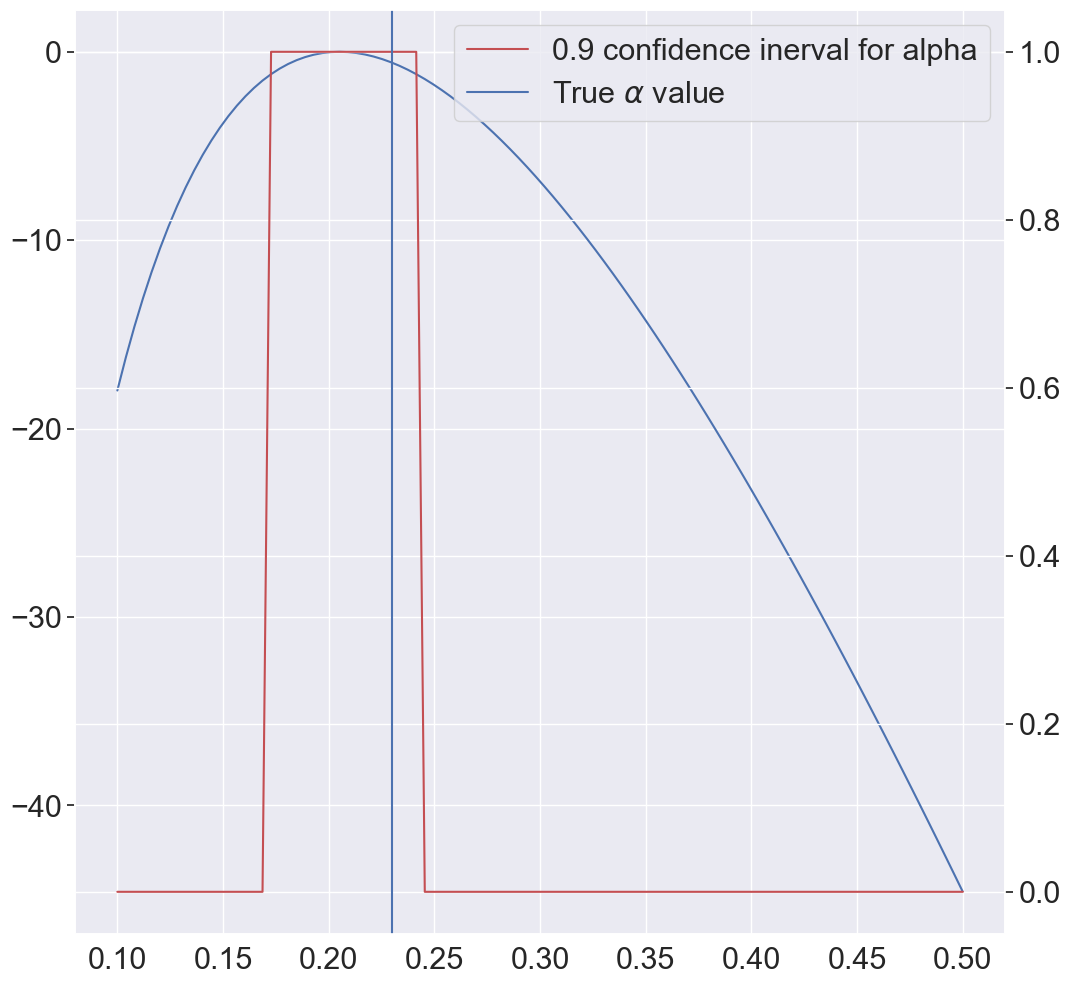

In [29]:
plt.figure(figsize=(12, 12))
plt.plot(alphas, 
         (np.array((log_likelihoods)) - log_likelihood_max), 
         label='Likelihood value')
plt.twinx()
plt.plot(alphas, 
         (np.array((log_likelihoods)) - log_likelihood_max > -cut_level), 
         c='r', label='{} confidence inerval for alpha'.format(q))
plt.axvline(alpha_true, label=r'True $\alpha$ value')
plt.legend()
plt.show()

### Профилируем likelihood по $\beta$

Делаем всё тоже самое

In [30]:
fit_alphas = []
fit_betas = []
log_likelihoods = []
betas = np.linspace(0.001, 10, 100)
for beta in betas:
    fit_alpha, _, fit_beta = gamma.fit(X, floc=0, fscale=1 / beta)
    fit_betas.append(1 / fit_beta)
    fit_alphas.append(fit_alpha)
    log_likelihoods.append(gamma.logpdf(X, loc=0, a=fit_alpha, scale=fit_beta).sum())

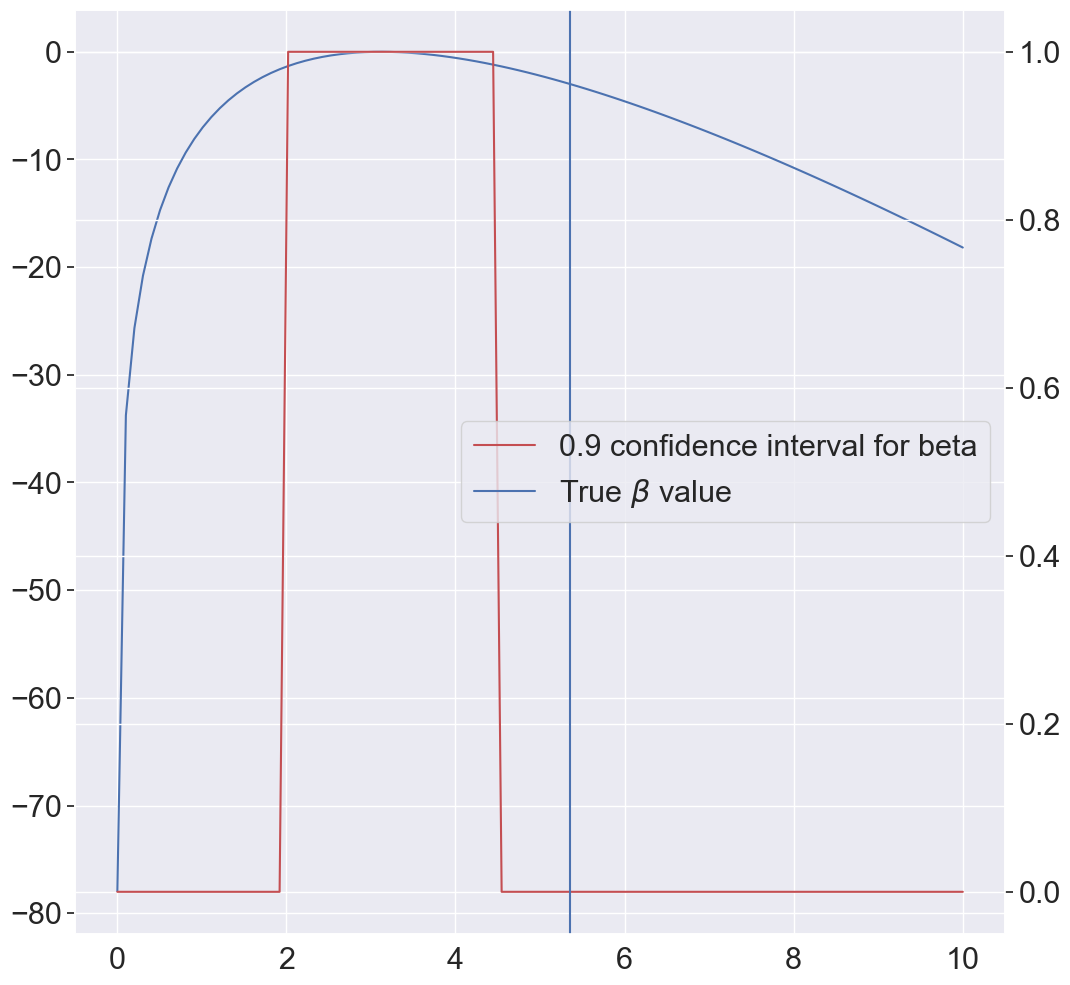

In [31]:
plt.figure(figsize=(12, 12))
plt.plot(betas, 
         (np.array((log_likelihoods)) - log_likelihood_max), 
         label='Likelihood value')
plt.twinx()
plt.plot(betas, 
         (np.array((log_likelihoods)) - log_likelihood_max > -cut_level), 
         c='r', label='{} confidence interval for beta'.format(q))
plt.axvline(beta_true, label=r'True $\beta$ value')
plt.legend()
plt.show()

### 2.2 2D профилирование likelihood

In [32]:
alphas, betas = np.meshgrid(alphas, betas)

In [33]:
alphas.shape

(100, 100)

In [34]:
log_likelihoods = []
for alpha, beta in zip(alphas.ravel(), betas.ravel()):
    log_likelihoods.append(gamma.logpdf(X, loc=0, a=alpha, scale=1 / beta).sum() - log_likelihood_max)

In [35]:
cut_level = chi2.ppf(q=q, df=2) / 2

In [36]:
log_likelihoods = np.array(log_likelihoods).reshape(alphas.shape)

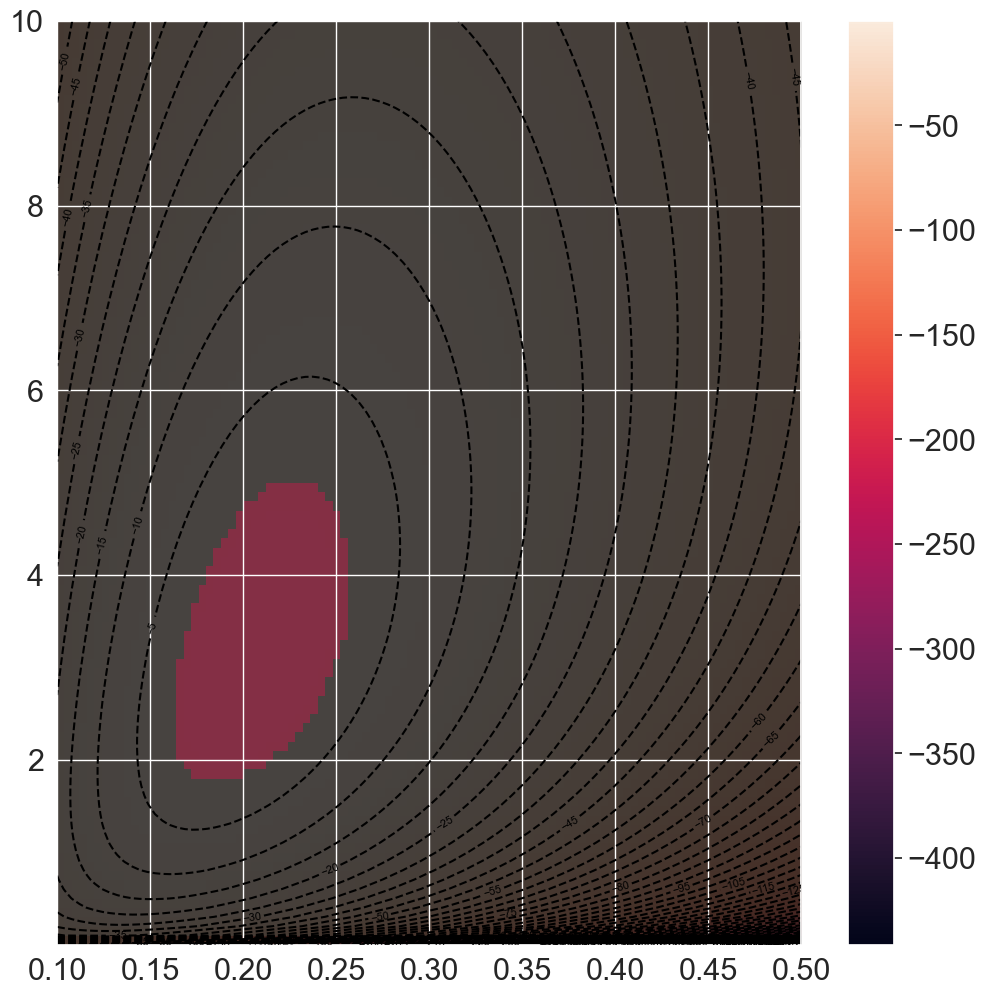

In [37]:
plt.figure(figsize=(12, 12))
contours = plt.contour(alphas, 
                       betas, 
                       log_likelihoods, 
                       100, 
                       colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(log_likelihoods, extent=[0.1, 0.5, 0.001, 10], 
           aspect='auto', origin='lower', alpha=1.)
plt.colorbar();

plt.imshow(100 * (log_likelihoods < -cut_level), 
           extent=[0.1, 0.5, 0.001, 10], 
           aspect='auto', origin='lower',
           cmap='RdGy', alpha=0.8)

## 2.2 Посчитаем покрытие для бернуллевской переменной

In [38]:
true_p = 0.5
q = st.norm.ppf(.98) # 90% интервал
log_likelihood = lambda x, n, theta, theta_hat: x * np.log(theta) + (n - x) * np.log(1 - theta)
cut_level = chi2.ppf(q=0.98, df=1) / 2

In [39]:
q, cut_level

(2.0537489106318225, 2.705947215527171)

In [40]:
coverage_likelihood = []
coverage_psi = []
coverage_theta = []

for i in range(1000000):
    x = np.random.binomial(n=1, p=true_p, size=10)
    p = np.clip(x.mean(), 1e-5, 1 - 1e-5)
    p_psi = psi(p)
    
    std_theta = 1 / np.sqrt(I_theta(x.sum(), len(x), p))
    std_psi = 1 / np.sqrt(I_psi(x.sum(), len(x), p))
    
    if p - q * std_theta < true_p < p + q * std_theta:
        coverage_theta.append(1)
    else:
        coverage_theta.append(0)
    
    if psi_inverse(p_psi - q * std_psi) < true_p < psi_inverse(p_psi + q * std_psi):
        coverage_psi.append(1)
    else:
        coverage_psi.append(0)
    
    if log_likelihood(x.sum(), len(x), true_p, p) - log_likelihood(x.sum(), len(x), p, p) > -cut_level:
        coverage_likelihood.append(1)
    else:
        coverage_likelihood.append(0)

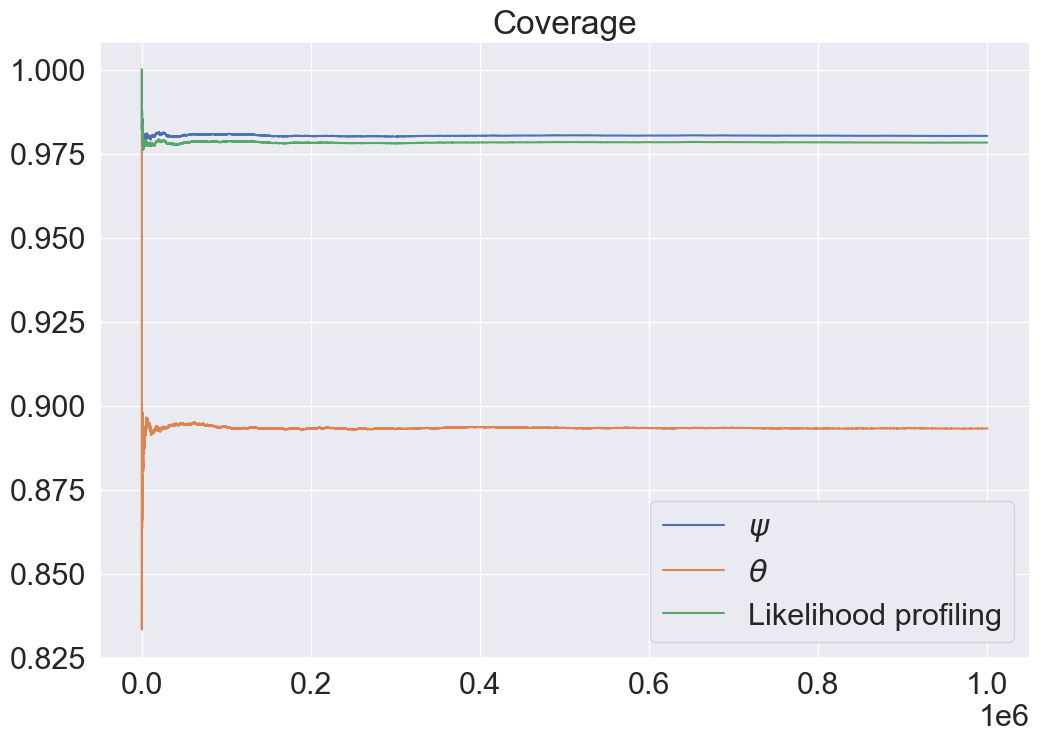

In [41]:
plt.figure(figsize=(12, 8))
plt.title("Coverage")
plt.plot(np.cumsum(coverage_psi) / np.cumsum(np.ones_like(coverage_psi)), label=r"$\psi$")
plt.plot(np.cumsum(coverage_theta) / np.cumsum(np.ones_like(coverage_theta)), label=r"$\theta$")
plt.plot(np.cumsum(coverage_likelihood) / np.cumsum(np.ones_like(coverage_likelihood)), label=r"Likelihood profiling")
plt.legend()

# 3. Применение информации Фишера для оценки доверительных интервалов и важности измерений 

Информацию Фишера можно использовать для расчёта ошибок в оценке параметров и корреляций ошибок. 

Это делается из [неравенства Крамера-Рао](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D0%9A%D1%80%D0%B0%D0%BC%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%A0%D0%B0%D0%BE), которое утверждает, что снизу оценки дисперсия параметра ограничена диагональным членом матрицы обратной к матрице Фишера.

$$\sigma^2(\theta_{\textrm{estimate}}) \geq \frac{1}{I(\theta)}$$

Посмотрим на оценку дисперсии параметров некоторого периодичного сигнала.

## 3.1 Фитирование кривой

### Постановка задачи

#### Условие

Пусть у нас есть некоторый сигнал:

$$a(t) = A \sin(2 \pi f t + \phi)$$


При передаче сигнала он зашумляется. __Предположим, что нам известна форма и параметры шума__: $\mathcal{N}(0, \sigma^2)$. Тогда мы будем наблюдать следующий сигнал в момент времени $t_i$:

$$\hat{a}_i \sim A \sin(2 \pi f t_i + \phi) + \mathcal{N}(0, \sigma^2) = \mathcal{N}\left(A \sin(2 \pi f t_i + \phi), \sigma^2 \right)$$


#### Задача

По набору измерений: $\{t_i\}_{i=1}^{N}$ и $\{\hat{a}_i\}_{i=1}^{N}$ мы хотим:
  * оценить ошибки восстановления параметров;
  * оценить "важность" какждого измерения для оценки каждого из параметров.

In [42]:
from scipy.misc import derivative
from scipy.optimize import curve_fit
import inspect
import matplotlib.pyplot as plt
import numpy as np

В качестве сигнала мы возьмём синус со следующими параметрами: амплитуда, частота и фаза.

Text(0.5, 0, 'time (s)')

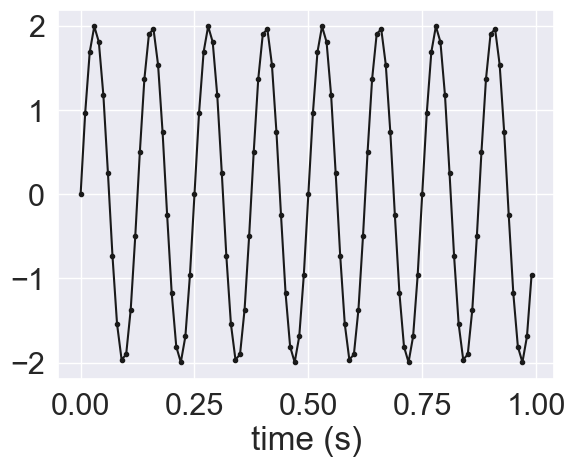

In [43]:
def signal(t, a, f, ph):
    return a * np.sin(2 * np.pi * f * t + ph)

parameters = {
    'a': 2,
    'f': 8,
    'ph': 0
}
noise = 0.1

T = np.arange(0, 1, 0.01)
plt.plot(T, signal(T, **parameters), '.-k')
plt.xlabel('time (s)')

### Вывод формул

Введём формальную терминологию.

Вектор параметров:

$$\theta = [A, f, \phi]$$

Вероятностная модель:

$$\hat{a}_i(\theta) \sim \mathcal{N}\left(A \sin(2 \pi f t_i + \phi), \sigma^2 \right)$$

$$\log p(\hat{a}_i) = - \frac{1}{2\sigma^2} \left( \hat{a}_i - A \sin(2 \pi f t_i + \phi)  \right)^2 - \log 2 \pi - \frac{1}{2} \log \sigma$$

Матрица Фишера для одного измерения:

$$\mathcal{I}(\theta) = \mathbb{E} \left( \left(\frac{\partial \log p(\hat{a}_i)}{\partial \theta}\right) \left(\frac{\partial \log p(\hat{a}_i)}{\partial \theta}\right)^T \right) = -\mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta^2} \right)$$


Найдём же эту вторую производную:

$$\frac{\partial \log p(\hat{a}_i)}{\partial \theta_i} = -\frac{1}{\sigma^2} a'_{\theta_i} \left( a(t_i) - \hat{a}_i \right)$$


$$\frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta_i \partial \theta_j} = -\frac{1}{\sigma^2} a''_{\theta_i,~\theta_j} \left( a(t_i) - \hat{a}_i \right) - \frac{1}{\sigma^2} a'_{\theta_i} a'_{\theta_j}$$ 

$$\mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta_i \partial \theta_j} \right) = - \frac{1}{\sigma^2} a'_{\theta_i} a'_{\theta_j}$$


Тогда матрица Фишера выражается следующим образом:

$$\mathcal{I} =  -\sum_i \mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta^2} \right) = \frac{1}{\sigma^2} \sum_i \left( \frac{\partial a(t_i)}{\partial \theta} \right) \left( \frac{\partial a(t_i)}{\partial \theta} \right)^T$$


Переопределим: $D_{mi} := \frac{\partial a(t_i)}{\partial \theta_m}$, тогда:

$$\mathcal{I}_{mn} = \frac{1}{\sigma^2} \sum_i \frac{\partial a(t_i)}{\partial \theta_m} \frac{\partial a(t_i)}{\partial \theta_n} = \frac{1}{\sigma^2} \sum_k D_{mi} D_{ni}$$

In [44]:
{**parameters, **{'a': 5}}

{'a': 5, 'f': 8, 'ph': 0}

In [45]:
derivative?

In [46]:
D = np.zeros((len(parameters), len(T)))

# для каждого параметра
for i, argname in enumerate(parameters.keys()):
    # для каждого измерения
    for k, t in enumerate(T):
        # определим функцию по которой будем считать производную
        func = lambda x: signal(t, **{**parameters, **{argname: x}})
        
        # посчитаем производную
        D[i,k] = derivative(func, parameters[argname], dx=0.0001)

/var/folders/0w/r6kn96y547sgcsd0_vh68ysm0000gn/T/ipykernel_50199/1545470938.py:11: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  D[i,k] = derivative(func, parameters[argname], dx=0.0001)


Посмотрим на зависимость $D$ для разных переменных. 

Заметим ещё раз, что по количество строк в матрице $D$ совпадает с длиной вектора $\theta$, а количество столбцов с количеством измерений.

In [47]:
D.shape

(3, 100)

Text(0.5, 0, 'time (s)')

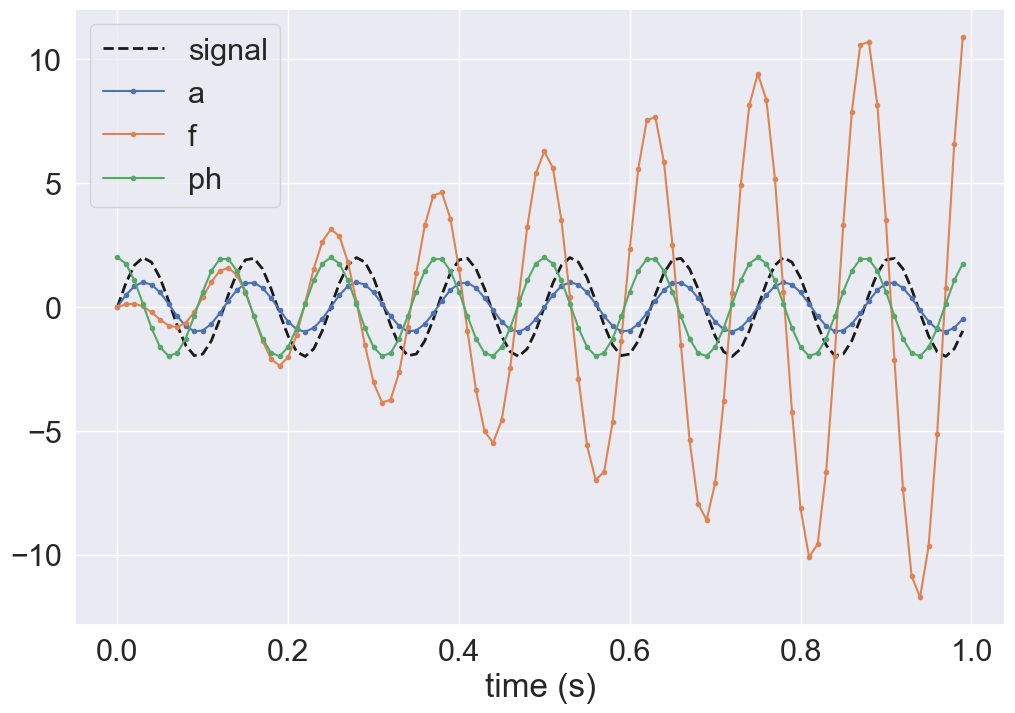

In [48]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(T, signal(T, **parameters), '--k', lw=2, label='signal')

for Di, argname in zip(D, parameters.keys()):
    plt.plot(T, Di, '.-', label=argname)
    
plt.legend(loc='best')
plt.xlabel('time (s)')

Матрица $D_{ik}$ показывает как сильно $k$-ое измерение влияет на $i$-ый параметр. К примеру, видно, что на параметр амплитуды сильнее всего влияют значения в пиках синуса. 

Кроме того, последние точки оказываются более чувствительными к частоте. 

А теперь посчитаем матрицу Фишера по матрице $D$:
$$\mathcal{I}_{m,n}= \frac{1}{\sigma^2} \sum_k D_{mk} D_{nk}$$

Посчитаем это с помощью функции из numpy: [```einsum```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html)

In [49]:
I = np.einsum('ij,kj', D, D) / noise**2
print(I)

[[ 5.00000000e+03 -5.71453545e+02 -1.42891218e-09]
 [-5.71453545e+02  2.55477009e+05  6.15752139e+04]
 [-1.42891218e-09  6.15752139e+04  1.99999999e+04]]


В ячейчке выше мы посмотрим на дисперсии оценок на параметры сигнала с помощью Крамера-Рао.

In [50]:
I_inv = np.linalg.inv(I)

for argname, variance in zip(parameters.keys(), I_inv.diagonal()):
    print('{}: {:.2g}'.format(argname, np.sqrt(variance)))

a: 0.014
f: 0.0039
ph: 0.014


А здесь мы воспользуемся функцией `curve_fit`, которая делает автоматический фит по конечной выборке и выдаёт оптимальные параметры и ошибки.

Как видно, они достаточно похожи.

Стоит отметить, что некорректно сравнивать ошибки посчитанные с помощью Крамера-Рао и `curve_fit`, так как они имеют достаточно разную природу. 

a: 0.015
f: 0.0041
ph: 0.015


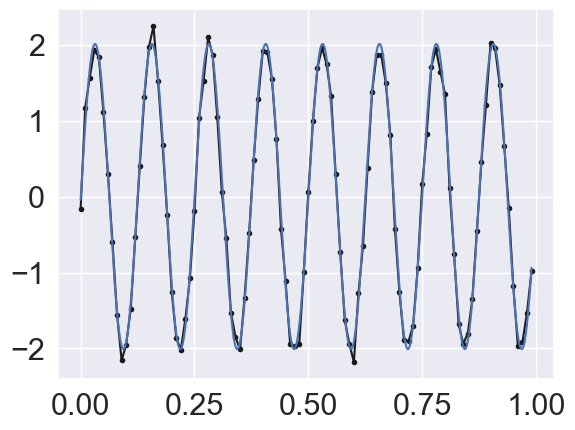

In [51]:
S = signal(T, **parameters) + np.random.randn(T.size) * noise
plt.plot(T, S, '.-k')

popt, pcov = curve_fit(signal, T, S, p0=list(parameters.values()))

for argname, variance in zip(parameters.keys(), pcov.diagonal()):
    print('{}: {:.2g}'.format(argname, np.sqrt(variance)))

Tl = np.linspace(T[0], T[-1], 10000)
plt.plot(Tl, signal(Tl, *popt))

In [52]:
def cramer_rao(model, p0, X, noise, show_plot=False):
    D = np.zeros((len(p0), X.size))
    for i, argname in enumerate(parameters.keys()):
        for k, t in enumerate(X):
            func = lambda x: signal(t, **{**parameters, **{argname: x}})
            D[i,k] = derivative(func, parameters[argname], dx=0.0001)
        
    if show_plot:
        plt.plot(X, model(X, **parameters), '--k', lw=2, label='signal')
        for Di, argname in zip(D, parameters.keys()):
            plt.plot(T, Di, '.-', label=argname)

        plt.legend(loc='best')
        plt.title('Зависимость параметра от ошибки измерения в конкретной точки')
    
    I = np.einsum('mk,nk', D, D) / noise**2
    I_inv = np.linalg.inv(I)
    
    return I_inv

На графике ниже мы показываем как ошибки в определённых точках влияют на оценку параметров $\theta$.

/var/folders/0w/r6kn96y547sgcsd0_vh68ysm0000gn/T/ipykernel_50199/3618196287.py:6: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  D[i,k] = derivative(func, parameters[argname], dx=0.0001)


Text(0.5, 0, 'time (s)')

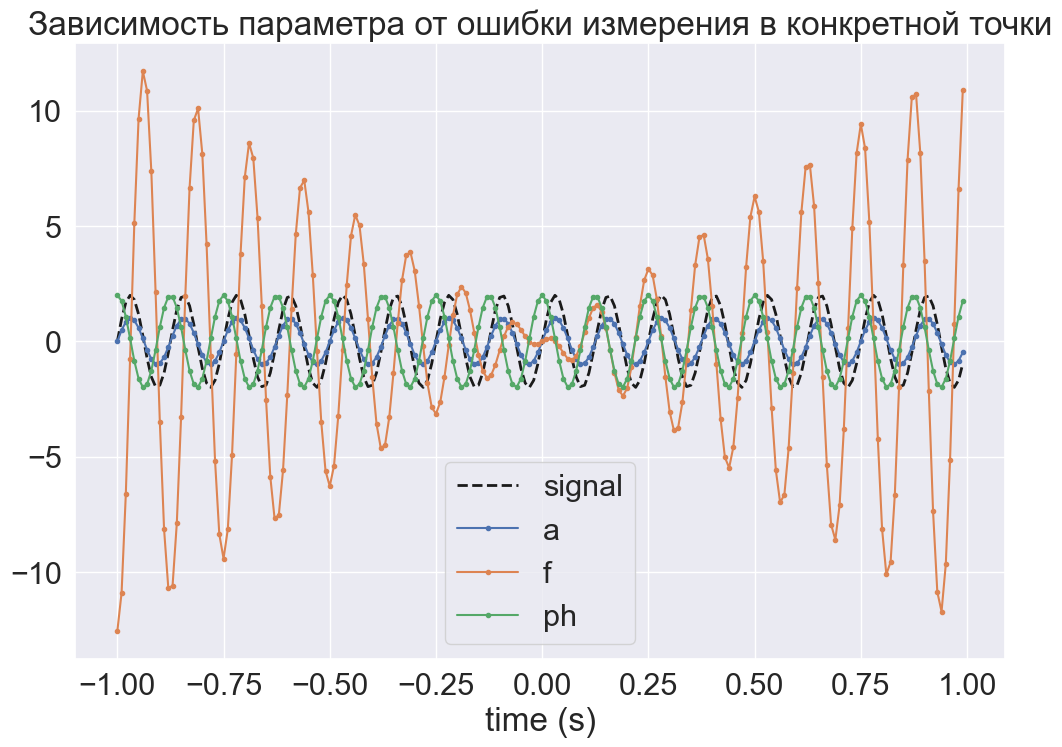

In [53]:
plt.figure(figsize=(12, 8), dpi=100)

T = np.arange(-1., 1, 0.01)
cramer_rao(signal, parameters, T, noise, show_plot=True);
plt.xlabel('time (s)')